In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import numpy.linalg as lng

In [2]:
class internal_layers(keras.layers.Layer):
    #units stands for the output dim, L is the number of the blocks (layers)
    def __init__(self, units, input_dim):
        super(internal_layers,self).__init__()
        
        self.input_dim=input_dim
        self.units=units
        
        #u variables
        uz_init=keras.initializers.GlorotNormal()
        self.uz=tf.Variable(initial_value=uz_init(shape=(self.input_dim, self.units), dtype="float32"),trainable=True)
        ug_init=keras.initializers.GlorotNormal()
        self.ug=tf.Variable(initial_value=ug_init(shape=(self.input_dim, self.units), dtype="float32"),trainable=True)
        ur_init=keras.initializers.GlorotNormal()
        self.ur=tf.Variable(initial_value=ur_init(shape=(self.input_dim, self.units), dtype="float32"),trainable=True)
        uh_init=keras.initializers.GlorotNormal()
        self.uh=tf.Variable(initial_value=uh_init(shape=(self.input_dim, self.units), dtype="float32"),trainable=True)
        
        #w variables
        wz_init=keras.initializers.GlorotNormal()
        self.wz=tf.Variable(initial_value=wz_init(shape=(self.units, self.units), dtype="float32"),trainable=True)
        wg_init=keras.initializers.GlorotNormal()
        self.wg=tf.Variable(initial_value=wg_init(shape=(self.units, self.units), dtype="float32"),trainable=True)
        wr_init=keras.initializers.GlorotNormal()
        self.wr=tf.Variable(initial_value=wr_init(shape=(self.units, self.units), dtype="float32"),trainable=True)
        wh_init=keras.initializers.GlorotNormal()
        self.wh=tf.Variable(initial_value=wh_init(shape=(self.units, self.units), dtype="float32"),trainable=True)
        
        
        bz_init=tf.zeros_initializer()
        self.bz=tf.Variable(initial_value=bz_init(shape=(1,self.units), dtype="float32"),trainable=True)
        bg_init=tf.zeros_initializer()
        self.bg=tf.Variable(initial_value=bg_init(shape=(1,self.units), dtype="float32"),trainable=True)
        br_init=tf.zeros_initializer()
        self.br=tf.Variable(initial_value=br_init(shape=(1,self.units), dtype="float32"),trainable=True)
        bh_init=tf.zeros_initializer()
        self.bh=tf.Variable(initial_value=bh_init(shape=(1,self.units), dtype="float32"),trainable=True)
        
        
        #S is the output of the previous layer, x is the vector from the data
    def call(self, S, x):     
        Z=keras.activations.tanh(tf.matmul(x,self.uz)+tf.matmul(S,self.wz)+self.bz)
        G=keras.activations.tanh(tf.matmul(x,self.ug)+tf.matmul(S,self.wg)+self.bg)
        R=keras.activations.tanh(tf.matmul(x,self.ur)+tf.matmul(S,self.wr)+self.br)
        H=keras.activations.tanh(tf.matmul(x,self.uh) + tf.matmul(tf.multiply(S, R),self.wh)+self.bh)
        S=tf.multiply(tf.ones_like(G)-G, H)+tf.multiply(Z,S)
                
        return S

In [3]:
class first_layer(keras.layers.Layer):
    def __init__(self, units, input_dim):
        super(first_layer,self).__init__()
        self.input_dim=input_dim
        self.units=units
        w_init=keras.initializers.GlorotNormal()
        self.w=tf.Variable(initial_value=w_init(shape=(self.input_dim, self.units), dtype="float32"),trainable=True)
        b_init=tf.zeros_initializer()
        self.b=tf.Variable(initial_value=b_init(shape=(1,self.units), dtype="float32"),trainable=True)
        
    def call(self,X):
        S=tf.add(tf.matmul(X, self.w), self.b)
        S=tf.tanh(S)
        return S              

class last_layer(keras.layers.Layer):
    def __init__(self, units, input_dim):
        super(last_layer,self).__init__()
        self.input_dim=input_dim
        self.units=units
        w_init=keras.initializers.GlorotNormal()
        self.w=tf.Variable(initial_value=w_init(shape=(self.input_dim, self.units), dtype="float32"),trainable=True)
        b_init=tf.zeros_initializer()
        self.b=tf.Variable(initial_value=b_init(shape=(1,self.units), dtype="float32"),trainable=True)
        
    def call(self,X):
        S=tf.add(tf.matmul(X, self.w), self.b)
        return S 

In [4]:
#now we should make a class for the model
class network(tf.keras.Model):
    #L is the number of the blocks (layers), M is layer height, d is the dimension of x
    def __init__(self, M, L, input_dim):
        super(network,self).__init__()
        
        self.first_layer1=first_layer(M,input_dim+1)
        self.L=L
        
        self.internal_layers_list=[]
        for _ in range(self.L):
            self.internal_layers_list.append(internal_layers(M, input_dim+1))
            
            
        self.final_layer=last_layer(1,M)
        
    def call(self,t,x):
        X=tf.concat([t,x],1)
        S=self.first_layer1.call(X)
        
        for i in range(self.L):
            S=self.internal_layers_list[i].call(S,X)        
        
        outcome=self.final_layer.call(S)
        
        return outcome

In [5]:
def moving_average(x,N):
    return np.convolve(x, np.ones(N)/N, mode='valid')

In [6]:
T=1
x_min=0
x_max=1

In [7]:
#now we have to define the sample function for the Burgers
def sample_Burgers(n_1, n_2, n_3):
    t_1=np.transpose((np.random.random(n_1)*T)[np.newaxis])
    x_1=np.transpose((np.random.random(n_1)*(x_max-x_min)+x_min)[np.newaxis])
    
    t_2=np.transpose((np.random.random(n_2)*T)[np.newaxis])
    x_2=np.transpose(np.random.binomial(size=n_2, n=1, p= 0.5)[np.newaxis]*(x_max-x_min)+x_min)
    
    t_3=np.zeros((n_3,1))
    x_3=np.transpose((np.random.random(n_3)*(x_max-x_min)+x_min)[np.newaxis])
    return t_1, x_1, t_2, x_2, t_3, x_3

In [32]:
#defining the objective function (thats the version that should be working):
def loss_burgers(model, t_for_x_interior, x_interior, t_for_x_boundary, x_boundary, t_L3, x_interior_L3):
    #have to put a and b also here, otherwise there will be dimensionality bug
    a=0.9
    b=-0.9
    eta=0.01
    alpha=0.95
    x_min=0
    x_max=1
    t_tensor=tf.convert_to_tensor(t_for_x_interior, dtype=tf.float32)
    x_tensor=tf.convert_to_tensor(x_interior, dtype=tf.float32)
    
    with tf.GradientTape(persistent=True) as g:
        g.watch(x_tensor)
        with tf.GradientTape(persistent=True) as t:
            t.watch(t_tensor)
            t.watch(x_tensor)
            f=model(t_tensor, x_tensor)
            
        fx=t.gradient(f, x_tensor)
        ft=t.gradient(f, t_tensor)         
    fxx=g.gradient(fx, x_tensor)
    del t
    del g
    

    J_1=tf.math.reduce_mean(tf.math.square(ft-eta*fxx+alpha*tf.math.multiply(x_interior,fx)))
    
    id_x_boundary_min=np.where(np.concatenate(x_boundary)==x_min)
    id_x_boundary_max=np.where(np.concatenate(x_boundary)==x_max)

    
    boundary_values_x_min=model(t_for_x_boundary[id_x_boundary_min],x_boundary[id_x_boundary_min])
    boundary_values_x_max=model(t_for_x_boundary[id_x_boundary_max],x_boundary[id_x_boundary_max])
    
    J_2=(tf.math.reduce_mean(tf.square(boundary_values_x_min-a))+tf.math.reduce_mean(tf.square(boundary_values_x_max-b)))/2
    
    h=x_interior_L3*(b-a)/(x_max-x_min)+a
    values_t_0=model(t_L3, x_interior_L3)
    
    J_3=tf.reduce_mean(tf.square(tf.convert_to_tensor(values_t_0-h))) 
    loss=J_1+J_2+J_3
    return loss, J_1, J_2, J_3

In [23]:
def grad(model, t_for_x_interior, x_interior, t_for_x_boundary, x_boundary, t_L3, x_interior_L3):
    with tf.GradientTape() as tape:
        loss_value, J_1, J_2, J_3 = loss_burgers(model, t_for_x_interior, x_interior, t_for_x_boundary, x_boundary, t_L3, x_interior_L3)
    return loss_value,J_1, J_2, J_3, tape.gradient(loss_value, model.trainable_variables)

In [99]:
T=1
x_min=0
x_max=1
M=300
L=8
#a at x_min and b at x_max, eta is multiplied by the second derivative and alpha by the first
a=0.9
b=-0.9
eta=0.01
alpha=0.95
learning_rate_value=0.0001
epochs=3000

In [100]:
%%time
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_value)
model=network(M,L,1)
loss_list=[]
J_1_list=[]
J_2_list=[]
J_3_list=[]
for i in range(epochs):
    b=sample_Burgers(40,40,40)
    loss_value,J_1, J_2, J_3, grads = grad(model, b[0], b[1], b[2], b[3], b[4], b[5])
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_list.append(loss_value)
    J_1_list.append(J_1)
    J_2_list.append(J_2)
    J_3_list.append(J_3)
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

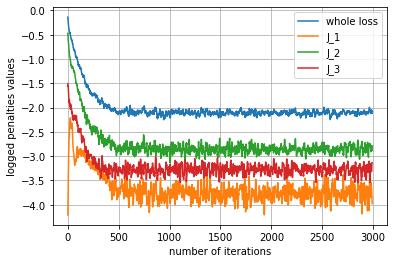

In [101]:
N=10
plt.plot(moving_average(np.log(loss_list),N), label="whole loss")
plt.plot(moving_average(np.log(J_1_list),N), label="J_1")
plt.plot(moving_average(np.log(J_2_list),N), label="J_2")
plt.plot(moving_average(np.log(J_3_list),N), label="J_3")
plt.legend(loc="upper right")
plt.xlabel("number of iterations")
plt.ylabel("logged penalties values")
plt.grid()
plt.show()

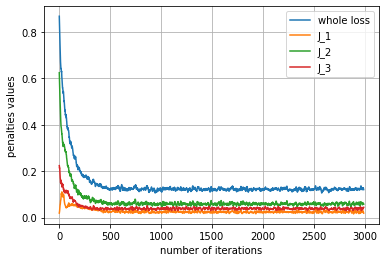

In [102]:
#moving average points
N=10
plt.plot(moving_average(loss_list,N), label="whole loss")
plt.plot(moving_average(J_1_list,N), label="J_1")
plt.plot(moving_average(J_2_list,N), label="J_2")
plt.plot(moving_average(J_3_list,N), label="J_3")
plt.legend(loc="upper right")
plt.xlabel("number of iterations")
plt.ylabel("penalties values")
plt.grid()
plt.show()

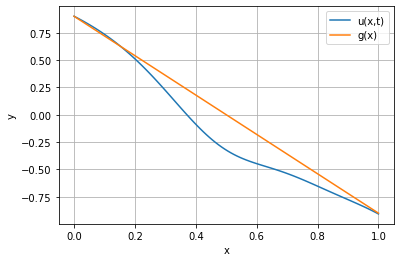

In [104]:
y=[]
for i in range (100):
    x=np.transpose((np.array([i*(x_max-x_min)+x_min]))[np.newaxis])/100
    t=np.transpose((np.array([0.]))[np.newaxis])
    y.append(model(t,x))

x=np.linspace(x_min,x_max, num=100)    
plt.plot(x,np.concatenate(np.asarray(y)),label="u(x,t)")
#for some reason need to give value to b and a yet again
a=0.9
b=-0.9
plt.plot(x,(x)*(b-a)/(x_max-x_min)+a, label="g(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend("Outcome of the computations")
plt.legend(loc="upper right")
plt.grid()
plt.show()

In [66]:
def loss_american_put(model, t_for_x_interior, x_interior, t_for_x_boundary, x_boundary, x_interior_L3):
    sigma=0.2
    r=0.1
    K=0.9
    x_min=0
    x_max=2.5
    t_tensor=tf.convert_to_tensor(t_for_x_interior, dtype=tf.float32)
    x_tensor=tf.convert_to_tensor(x_interior, dtype=tf.float32)    
        
    with tf.GradientTape(persistent=True) as g:
        g.watch(x_tensor)
        with tf.GradientTape(persistent=True) as t:
            t.watch(t_tensor)
            t.watch(x_tensor)
            f=model(t_tensor, x_tensor)
            
        fx=t.gradient(f, x_tensor)
        ft=t.gradient(f, t_tensor)         
    fxx=g.gradient(fx, x_tensor)
    del t
    del g
    
    #sometimes after the filtration x_tensor is empty, then we have to do something. The choice for J_1 to be zero is probably 
    #not the best one, but for the gradient descent (so also model training) it will do no difference
    if ((tf.equal(tf.size(fxx),0)) or (x_interior.size==0) ) :
        J_1=0    
       
    else:    
        error=ft+r*tf.math.multiply(x_interior,fx)+1/2*sigma*sigma*tf.math.multiply(x_interior**2,fxx)-r*f
        J_1=tf.math.reduce_mean(tf.math.square(error))
    
    if tf.equal(tf.size(x_boundary),0):
        J_2=0
    else:
        f_2=model(t_for_x_boundary, x_boundary)
        g=np.maximum(K-x_boundary,0)
        J_2=tf.math.reduce_mean(tf.square(np.maximum(g-f_2,0)))
    
    g_3=np.maximum(K-x_interior_L3,0)
    values_L3=model(np.ones_like(x_interior_L3)*T, x_interior_L3)
    J_3=tf.reduce_mean(tf.square(values_L3-g_3)) 
    loss=J_1+J_2+J_3
    return loss, J_1, J_2, J_3


In [41]:
def sample_american_put(n_1, n_2, n_3):
    t_1=np.transpose((np.random.random(n_1)*T)[np.newaxis])
    x_1=np.transpose((np.random.random(n_1)*(x_max-x_min)+x_min)[np.newaxis])
    
    t_2=np.transpose((np.random.random(n_2)*T)[np.newaxis])
    x_2=np.transpose((np.random.random(n_2)*(x_max-x_min)+x_min)[np.newaxis])
    
    x_3=np.transpose((np.random.random(n_3)*(x_max-x_min)+x_min)[np.newaxis])
    return t_1, x_1, t_2, x_2, x_3

In [42]:
def grad_american(model, t_for_x_interior, x_interior, t_for_x_boundary, x_boundary, x_interior_L3):
    with tf.GradientTape() as tape:
        loss_value, J_1, J_2, J_3 = loss_american_put(model, t_for_x_interior, x_interior, t_for_x_boundary, x_boundary, x_interior_L3)
    return loss_value,J_1, J_2, J_3, tape.gradient(loss_value, model.trainable_variables)

In [68]:
#for the american put (one dimensional) we set:
T=1
sigma=0.2
r=0.1
K=0.9
x_min=0
x_max=2.5
M=50
L=3
learning_rate_value=0.002
epochs=3000

In [69]:
%%time
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_value)
model=network(M,L,1)
loss_list=[]
J_1_list=[]
J_2_list=[]
J_3_list=[]
for i in range(epochs):
    #I am putting way bigger sample size for the first two terms of the loss function since we need to filter out some of them
    b=sample_american_put(200,200,40)
    outcome_1=model(b[0],b[1])
    id_x_interior=np.where(np.concatenate(outcome_1)>np.maximum(K-np.concatenate(b[1]),0))
    outcome_2=model(b[2],b[3])
    id_x_boundary=np.where(np.concatenate(outcome_2)<=np.maximum(K-np.concatenate(b[3]),0))
    
    loss_value,J_1, J_2, J_3, grads = grad_american(model, b[0][id_x_interior], b[1][id_x_interior], b[2][id_x_boundary], b[3][id_x_boundary], b[4])
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    loss_list.append(loss_value)
    J_1_list.append(J_1)
    J_2_list.append(J_2)
    J_3_list.append(J_3)
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

<ipython-input-80-ebef73dd7f35>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(moving_average(np.log(J_1_list),N), label="log(J_1)")


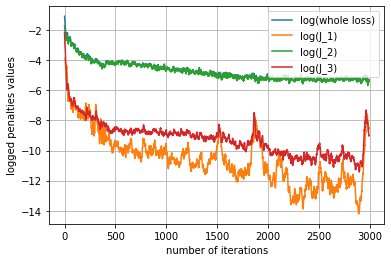

In [80]:
N=10
plt.plot(moving_average(np.log(loss_list),N), label="log(whole loss)")
plt.plot(moving_average(np.log(J_1_list),N), label="log(J_1)")
plt.plot(moving_average(np.log(J_2_list),N), label="log(J_2)")
plt.plot(moving_average(np.log(J_3_list),N), label="log(J_3)")
plt.legend(loc="upper right")
plt.xlabel("number of iterations")
plt.ylabel("logged penalties values")
plt.grid()
plt.show()

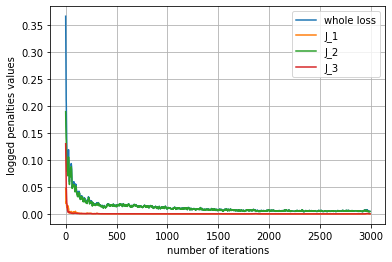

In [71]:
#moving average points
N=10
plt.plot(moving_average(loss_list,N), label="whole loss")
plt.plot(moving_average(J_1_list,N), label="J_1")
plt.plot(moving_average(J_2_list,N), label="J_2")
plt.plot(moving_average(J_3_list,N), label="J_3")
plt.legend(loc="upper right")
plt.xlabel("number of iterations")
plt.ylabel("penalties values")
plt.grid()
plt.show()

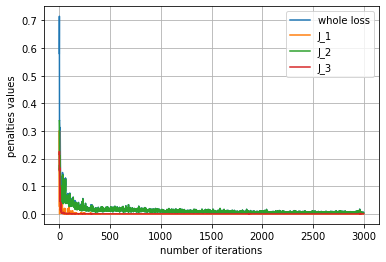

In [73]:
plt.plot(loss_list, label="whole loss")
plt.plot(J_1_list, label="J_1")
plt.plot(J_2_list, label="J_2")
plt.plot(J_3_list, label="J_3")
plt.legend(loc="upper right")
plt.xlabel("number of iterations")
plt.ylabel("penalties values")
plt.grid()
plt.show()

In order to judge the quality of computations we will use a piece of codee from another project, solving the same PDE using splitting Crank-Nicolson scheme (so it's finite differences scheme)

In [74]:
def phi(S,I):
    return np.maximum(K-S,0.).reshape(I,1)
def vL(t,S_min):
    return K-S_min
def vR(t):
    return 0
def CN_Split(N,U,A,delta_t,alpha,beta,S_min,I):
    q=np.zeros_like(U)
    g=U
    for n in range(N):
        t=delta_t*(n+1)
        q[0]=(-alpha[0]+beta[0])*vL(t,S_min)
        q[-1]=(-alpha[-1]-beta[-1])*vR(t)
        U=lng.solve(np.eye(I)+delta_t*A/2,(np.eye(I)-delta_t*A/2) @(U)-delta_t*q)
        U=np.maximum(U,g)
        g=U
    return U.reshape(I,1)

In [75]:
%%time
iteration_range=zip([639], [640])
for I,N in iteration_range:
    start_time=time.time()
    h=(x_max-x_min)/(I+1)
    delta_t=T/N
    S=x_min*np.ones(I)+h*np.arange(1,I+1)
    alpha=(sigma**2/2)*(S**2/h**2)
    beta=r*S/(2*h)
    r_vec=np.ones(I)*r
    A=np.diag(2*alpha+r_vec)+np.diag(-alpha[1:]+beta[1:],-1)+np.diag(-alpha[0:-1]-beta[:-1],1)
    U=phi(S,I)
    U=CN_Split(N,U,A,delta_t,alpha,beta,x_min,I)

Wall time: 18.3 s


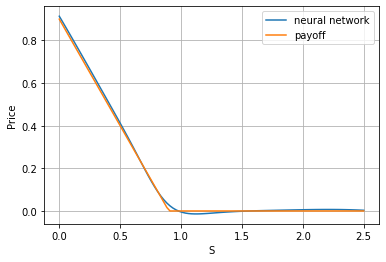

In [78]:
y=[]
for i in range (100):
    x=np.transpose((np.array([i*(x_max-x_min)+x_min]))[np.newaxis])/100
    t=np.transpose((np.array([1.]))[np.newaxis])
    y.append(model(t,x))

x=np.linspace(x_min,x_max, num=100)
plt.plot(x,np.concatenate(np.asarray(y)),label="neural network")
plt.plot(x,np.maximum(K-x,0), label="payoff")
#plt.plot(S,U, label="CN scheme")
plt.xlabel("S")
plt.ylabel("Price")
plt.legend("Outcome of the computations")
plt.legend(loc="upper right")
plt.grid()
plt.show()